In [13]:
import os
import cv2
import numpy as np
from tqdm import tqdm # progress bar

REBUILD_DATA = False

In [11]:
class PetClassification:
    IMG_SIZE = 50
    CATS = "../data/PetImages/Cat"
    DOGS = "../data/PetImages/Dog"
    LABELS = {CATS:0, DOGS:1}
    training_data = []
    catcount = 0
    dogcount = 0
    
    # import training data into NP array - only needs to be run once
    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label, f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

                    if (label == self.CATS):
                        self.catcount += 1
                    elif (label == self.DOGS):
                        self.dogcount += 1
                except Exception as e:
                    # in case corrupted data
                    pass
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print("Cats: ", self.catcount, " Dogs: ", self.dogcount)        

In [12]:
if REBUILD_DATA:
    pc = PetClassification()
    pc.make_training_data()

  0%|          | 56/12501 [00:00<00:22, 550.62it/s]

../data/PetImages/Cat


  0%|          | 49/12501 [00:00<00:25, 479.97it/s]

../data/PetImages/Dog


100%|██████████| 12501/12501 [00:21<00:00, 587.08it/s]


Cats:  12476  Dogs:  12470


In [15]:
training_data = np.load("training_data.npy", allow_pickle=True)

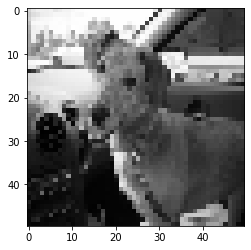

In [26]:
import matplotlib.pyplot as plt

plt.imshow(training_data[2][0], cmap="gray")
plt.show()

In [42]:
# model
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        x = torch.randn(50, 50).view(-1, 1, 50, 50)
        self._to_linear = None
        self.convs(x)
        # flatten in keras
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 2)
        
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        
        print(x[0].shape)
        if (self._to_linear is None):
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        # can help to have softmax function at the end
        return F.softmax(x, dim=1)
    

In [43]:
net = Net()

torch.Size([128, 2, 2])


In [45]:
import torch.optim as optim

optimiser = optim.Adam(net.parameters(), lr = 0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)

print(val_size)

2494


In [46]:
train_X = X[:-val_size]
train_y = y[:-val_size]
test_X = X[-val_size:]
test_y = y[-val_size:]

In [50]:
BATCH_SIZE = 100
EPOCHS = 1

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        print(i, i+BATCH_SIZE)
        batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
        batch_y = train_y[i:i+BATCH_SIZE]
        
        optimiser.zero_grad()
        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimiser.step()

print(loss)


  0%|          | 0/225 [00:00<?, ?it/s]

0 100
torch.Size([128, 2, 2])



  0%|          | 1/225 [00:00<01:27,  2.56it/s]

100 200
torch.Size([128, 2, 2])



  1%|          | 2/225 [00:00<01:18,  2.85it/s]

200 300
torch.Size([128, 2, 2])



  1%|▏         | 3/225 [00:00<01:14,  2.97it/s]

300 400
torch.Size([128, 2, 2])



  2%|▏         | 4/225 [00:01<01:18,  2.82it/s]

400 500
torch.Size([128, 2, 2])



  2%|▏         | 5/225 [00:01<01:13,  2.99it/s]

500 600
torch.Size([128, 2, 2])



  3%|▎         | 6/225 [00:01<01:08,  3.17it/s]

600 700
torch.Size([128, 2, 2])



  3%|▎         | 7/225 [00:02<01:12,  3.01it/s]

700 800
torch.Size([128, 2, 2])



  4%|▎         | 8/225 [00:02<01:07,  3.19it/s]

800 900
torch.Size([128, 2, 2])



  4%|▍         | 9/225 [00:02<01:08,  3.15it/s]

900 1000
torch.Size([128, 2, 2])



  4%|▍         | 10/225 [00:03<01:06,  3.24it/s]

1000 1100
torch.Size([128, 2, 2])



  5%|▍         | 11/225 [00:03<01:07,  3.16it/s]

1100 1200
torch.Size([128, 2, 2])



  5%|▌         | 12/225 [00:03<01:05,  3.26it/s]

1200 1300
torch.Size([128, 2, 2])



  6%|▌         | 13/225 [00:04<01:07,  3.12it/s]

1300 1400
torch.Size([128, 2, 2])



  6%|▌         | 14/225 [00:04<01:08,  3.07it/s]

1400 1500
torch.Size([128, 2, 2])



  7%|▋         | 15/225 [00:04<01:07,  3.13it/s]

1500 1600
torch.Size([128, 2, 2])



  7%|▋         | 16/225 [00:05<01:05,  3.19it/s]

1600 1700
torch.Size([128, 2, 2])



  8%|▊         | 17/225 [00:05<01:03,  3.29it/s]

1700 1800
torch.Size([128, 2, 2])



  8%|▊         | 18/225 [00:05<01:01,  3.35it/s]

1800 1900
torch.Size([128, 2, 2])



  8%|▊         | 19/225 [00:05<00:59,  3.46it/s]

1900 2000
torch.Size([128, 2, 2])



  9%|▉         | 20/225 [00:06<00:58,  3.50it/s]

2000 2100
torch.Size([128, 2, 2])



  9%|▉         | 21/225 [00:06<00:57,  3.55it/s]

2100 2200
torch.Size([128, 2, 2])



 10%|▉         | 22/225 [00:06<01:00,  3.36it/s]

2200 2300
torch.Size([128, 2, 2])



 10%|█         | 23/225 [00:07<01:01,  3.30it/s]

2300 2400
torch.Size([128, 2, 2])



 11%|█         | 24/225 [00:07<00:57,  3.48it/s]

2400 2500
torch.Size([128, 2, 2])



 11%|█         | 25/225 [00:07<00:56,  3.51it/s]

2500 2600
torch.Size([128, 2, 2])



 12%|█▏        | 26/225 [00:07<00:55,  3.60it/s]

2600 2700
torch.Size([128, 2, 2])



 12%|█▏        | 27/225 [00:08<00:55,  3.57it/s]

2700 2800
torch.Size([128, 2, 2])



 12%|█▏        | 28/225 [00:08<00:58,  3.39it/s]

2800 2900
torch.Size([128, 2, 2])



 13%|█▎        | 29/225 [00:08<00:58,  3.38it/s]

2900 3000
torch.Size([128, 2, 2])



 13%|█▎        | 30/225 [00:09<00:55,  3.51it/s]

3000 3100
torch.Size([128, 2, 2])



 14%|█▍        | 31/225 [00:09<00:59,  3.27it/s]

3100 3200
torch.Size([128, 2, 2])



 14%|█▍        | 32/225 [00:09<00:58,  3.30it/s]

3200 3300
torch.Size([128, 2, 2])



 15%|█▍        | 33/225 [00:10<00:57,  3.31it/s]

3300 3400
torch.Size([128, 2, 2])



 15%|█▌        | 34/225 [00:10<00:58,  3.26it/s]

3400 3500
torch.Size([128, 2, 2])



 16%|█▌        | 35/225 [00:10<00:58,  3.22it/s]

3500 3600
torch.Size([128, 2, 2])



 16%|█▌        | 36/225 [00:10<00:58,  3.22it/s]

3600 3700
torch.Size([128, 2, 2])



 16%|█▋        | 37/225 [00:11<00:55,  3.39it/s]

3700 3800
torch.Size([128, 2, 2])



 17%|█▋        | 38/225 [00:11<00:57,  3.25it/s]

3800 3900
torch.Size([128, 2, 2])



 17%|█▋        | 39/225 [00:11<00:54,  3.43it/s]

3900 4000
torch.Size([128, 2, 2])



 18%|█▊        | 40/225 [00:12<00:55,  3.36it/s]

4000 4100
torch.Size([128, 2, 2])



 18%|█▊        | 41/225 [00:12<01:00,  3.06it/s]

4100 4200
torch.Size([128, 2, 2])



 19%|█▊        | 42/225 [00:12<01:00,  3.04it/s]

4200 4300
torch.Size([128, 2, 2])



 19%|█▉        | 43/225 [00:13<01:00,  2.99it/s]

4300 4400
torch.Size([128, 2, 2])



 20%|█▉        | 44/225 [00:13<00:58,  3.11it/s]

4400 4500
torch.Size([128, 2, 2])



 20%|██        | 45/225 [00:13<00:59,  3.04it/s]

4500 4600
torch.Size([128, 2, 2])



 20%|██        | 46/225 [00:14<00:59,  2.99it/s]

4600 4700
torch.Size([128, 2, 2])



 21%|██        | 47/225 [00:14<00:54,  3.24it/s]

4700 4800
torch.Size([128, 2, 2])



 21%|██▏       | 48/225 [00:14<00:52,  3.38it/s]

4800 4900
torch.Size([128, 2, 2])



 22%|██▏       | 49/225 [00:14<00:50,  3.49it/s]

4900 5000
torch.Size([128, 2, 2])



 22%|██▏       | 50/225 [00:15<00:57,  3.05it/s]

5000 5100
torch.Size([128, 2, 2])



 23%|██▎       | 51/225 [00:15<01:01,  2.83it/s]

5100 5200
torch.Size([128, 2, 2])



 23%|██▎       | 52/225 [00:16<01:08,  2.53it/s]

5200 5300
torch.Size([128, 2, 2])



 24%|██▎       | 53/225 [00:16<01:04,  2.68it/s]

5300 5400
torch.Size([128, 2, 2])



 24%|██▍       | 54/225 [00:16<01:00,  2.84it/s]

5400 5500
torch.Size([128, 2, 2])



 24%|██▍       | 55/225 [00:17<00:54,  3.11it/s]

5500 5600
torch.Size([128, 2, 2])



 25%|██▍       | 56/225 [00:17<00:54,  3.11it/s]

5600 5700
torch.Size([128, 2, 2])



 25%|██▌       | 57/225 [00:17<00:52,  3.20it/s]

5700 5800
torch.Size([128, 2, 2])



 26%|██▌       | 58/225 [00:18<00:52,  3.16it/s]

5800 5900
torch.Size([128, 2, 2])



 26%|██▌       | 59/225 [00:18<00:49,  3.37it/s]

5900 6000
torch.Size([128, 2, 2])



 27%|██▋       | 60/225 [00:18<00:46,  3.53it/s]

6000 6100
torch.Size([128, 2, 2])



 27%|██▋       | 61/225 [00:18<00:44,  3.65it/s]

6100 6200
torch.Size([128, 2, 2])



 28%|██▊       | 62/225 [00:19<00:49,  3.28it/s]

6200 6300
torch.Size([128, 2, 2])



 28%|██▊       | 63/225 [00:19<00:48,  3.33it/s]

6300 6400
torch.Size([128, 2, 2])



 28%|██▊       | 64/225 [00:19<00:46,  3.43it/s]

6400 6500
torch.Size([128, 2, 2])



 29%|██▉       | 65/225 [00:20<00:49,  3.23it/s]

6500 6600
torch.Size([128, 2, 2])



 29%|██▉       | 66/225 [00:20<00:46,  3.40it/s]

6600 6700
torch.Size([128, 2, 2])



 30%|██▉       | 67/225 [00:20<00:48,  3.25it/s]

6700 6800
torch.Size([128, 2, 2])



 30%|███       | 68/225 [00:21<00:48,  3.27it/s]

6800 6900
torch.Size([128, 2, 2])



 31%|███       | 69/225 [00:21<00:45,  3.40it/s]

6900 7000
torch.Size([128, 2, 2])



 31%|███       | 70/225 [00:21<00:44,  3.52it/s]

7000 7100
torch.Size([128, 2, 2])



 32%|███▏      | 71/225 [00:21<00:44,  3.46it/s]

7100 7200
torch.Size([128, 2, 2])



 32%|███▏      | 72/225 [00:22<00:44,  3.42it/s]

7200 7300
torch.Size([128, 2, 2])



 32%|███▏      | 73/225 [00:22<00:46,  3.26it/s]

7300 7400
torch.Size([128, 2, 2])



 33%|███▎      | 74/225 [00:22<00:49,  3.06it/s]

7400 7500
torch.Size([128, 2, 2])



 33%|███▎      | 75/225 [00:23<00:49,  3.03it/s]

7500 7600
torch.Size([128, 2, 2])



 34%|███▍      | 76/225 [00:23<00:46,  3.21it/s]

7600 7700
torch.Size([128, 2, 2])



 34%|███▍      | 77/225 [00:23<00:45,  3.25it/s]

7700 7800
torch.Size([128, 2, 2])



 35%|███▍      | 78/225 [00:24<00:44,  3.33it/s]

7800 7900
torch.Size([128, 2, 2])



 35%|███▌      | 79/225 [00:24<00:45,  3.19it/s]

7900 8000
torch.Size([128, 2, 2])



 36%|███▌      | 80/225 [00:24<00:43,  3.32it/s]

8000 8100
torch.Size([128, 2, 2])



 36%|███▌      | 81/225 [00:24<00:41,  3.50it/s]

8100 8200
torch.Size([128, 2, 2])



 36%|███▋      | 82/225 [00:25<00:39,  3.59it/s]

8200 8300
torch.Size([128, 2, 2])



 37%|███▋      | 83/225 [00:25<00:40,  3.53it/s]

8300 8400
torch.Size([128, 2, 2])



 37%|███▋      | 84/225 [00:25<00:38,  3.62it/s]

8400 8500
torch.Size([128, 2, 2])



 38%|███▊      | 85/225 [00:26<00:37,  3.69it/s]

8500 8600
torch.Size([128, 2, 2])



 38%|███▊      | 86/225 [00:26<00:37,  3.74it/s]

8600 8700
torch.Size([128, 2, 2])



 39%|███▊      | 87/225 [00:26<00:37,  3.64it/s]

8700 8800
torch.Size([128, 2, 2])



 39%|███▉      | 88/225 [00:26<00:36,  3.75it/s]

8800 8900
torch.Size([128, 2, 2])



 40%|███▉      | 89/225 [00:27<00:36,  3.72it/s]

8900 9000
torch.Size([128, 2, 2])



 40%|████      | 90/225 [00:27<00:35,  3.80it/s]

9000 9100
torch.Size([128, 2, 2])



 40%|████      | 91/225 [00:27<00:37,  3.58it/s]

9100 9200
torch.Size([128, 2, 2])



 41%|████      | 92/225 [00:27<00:36,  3.62it/s]

9200 9300
torch.Size([128, 2, 2])



 41%|████▏     | 93/225 [00:28<00:38,  3.44it/s]

9300 9400
torch.Size([128, 2, 2])



 42%|████▏     | 94/225 [00:28<00:38,  3.40it/s]

9400 9500
torch.Size([128, 2, 2])



 42%|████▏     | 95/225 [00:28<00:36,  3.54it/s]

9500 9600
torch.Size([128, 2, 2])



 43%|████▎     | 96/225 [00:29<00:36,  3.49it/s]

9600 9700
torch.Size([128, 2, 2])



 43%|████▎     | 97/225 [00:29<00:37,  3.44it/s]

9700 9800
torch.Size([128, 2, 2])



 44%|████▎     | 98/225 [00:29<00:37,  3.41it/s]

9800 9900
torch.Size([128, 2, 2])



 44%|████▍     | 99/225 [00:30<00:40,  3.13it/s]

9900 10000
torch.Size([128, 2, 2])



 44%|████▍     | 100/225 [00:30<00:37,  3.32it/s]

10000 10100
torch.Size([128, 2, 2])



 45%|████▍     | 101/225 [00:30<00:35,  3.50it/s]

10100 10200
torch.Size([128, 2, 2])



 45%|████▌     | 102/225 [00:30<00:36,  3.36it/s]

10200 10300
torch.Size([128, 2, 2])



 46%|████▌     | 103/225 [00:31<00:38,  3.16it/s]

10300 10400
torch.Size([128, 2, 2])



 46%|████▌     | 104/225 [00:31<00:37,  3.21it/s]

10400 10500
torch.Size([128, 2, 2])



 47%|████▋     | 105/225 [00:31<00:36,  3.28it/s]

10500 10600
torch.Size([128, 2, 2])



 47%|████▋     | 106/225 [00:32<00:35,  3.39it/s]

10600 10700
torch.Size([128, 2, 2])



 48%|████▊     | 107/225 [00:32<00:36,  3.21it/s]

10700 10800
torch.Size([128, 2, 2])



 48%|████▊     | 108/225 [00:32<00:36,  3.21it/s]

10800 10900
torch.Size([128, 2, 2])



 48%|████▊     | 109/225 [00:33<00:35,  3.30it/s]

10900 11000
torch.Size([128, 2, 2])



 49%|████▉     | 110/225 [00:33<00:33,  3.42it/s]

11000 11100
torch.Size([128, 2, 2])



 49%|████▉     | 111/225 [00:33<00:34,  3.32it/s]

11100 11200
torch.Size([128, 2, 2])



 50%|████▉     | 112/225 [00:33<00:32,  3.45it/s]

11200 11300
torch.Size([128, 2, 2])



 50%|█████     | 113/225 [00:34<00:31,  3.57it/s]

11300 11400
torch.Size([128, 2, 2])



 51%|█████     | 114/225 [00:34<00:30,  3.61it/s]

11400 11500
torch.Size([128, 2, 2])



 51%|█████     | 115/225 [00:34<00:30,  3.57it/s]

11500 11600
torch.Size([128, 2, 2])



 52%|█████▏    | 116/225 [00:35<00:29,  3.72it/s]

11600 11700
torch.Size([128, 2, 2])



 52%|█████▏    | 117/225 [00:35<00:29,  3.68it/s]

11700 11800
torch.Size([128, 2, 2])



 52%|█████▏    | 118/225 [00:35<00:28,  3.75it/s]

11800 11900
torch.Size([128, 2, 2])



 53%|█████▎    | 119/225 [00:35<00:29,  3.55it/s]

11900 12000
torch.Size([128, 2, 2])



 53%|█████▎    | 120/225 [00:36<00:30,  3.44it/s]

12000 12100
torch.Size([128, 2, 2])



 54%|█████▍    | 121/225 [00:36<00:29,  3.56it/s]

12100 12200
torch.Size([128, 2, 2])



 54%|█████▍    | 122/225 [00:36<00:28,  3.63it/s]

12200 12300
torch.Size([128, 2, 2])



 55%|█████▍    | 123/225 [00:36<00:27,  3.75it/s]

12300 12400
torch.Size([128, 2, 2])



 55%|█████▌    | 124/225 [00:37<00:27,  3.61it/s]

12400 12500
torch.Size([128, 2, 2])



 56%|█████▌    | 125/225 [00:37<00:29,  3.38it/s]

12500 12600
torch.Size([128, 2, 2])



 56%|█████▌    | 126/225 [00:37<00:28,  3.49it/s]

12600 12700
torch.Size([128, 2, 2])



 56%|█████▋    | 127/225 [00:38<00:28,  3.44it/s]

12700 12800
torch.Size([128, 2, 2])



 57%|█████▋    | 128/225 [00:38<00:27,  3.49it/s]

12800 12900
torch.Size([128, 2, 2])



 57%|█████▋    | 129/225 [00:38<00:28,  3.34it/s]

12900 13000
torch.Size([128, 2, 2])



 58%|█████▊    | 130/225 [00:39<00:27,  3.43it/s]

13000 13100
torch.Size([128, 2, 2])



 58%|█████▊    | 131/225 [00:39<00:27,  3.40it/s]

13100 13200
torch.Size([128, 2, 2])



 59%|█████▊    | 132/225 [00:39<00:28,  3.30it/s]

13200 13300
torch.Size([128, 2, 2])



 59%|█████▉    | 133/225 [00:39<00:28,  3.20it/s]

13300 13400
torch.Size([128, 2, 2])



 60%|█████▉    | 134/225 [00:40<00:30,  3.02it/s]

13400 13500
torch.Size([128, 2, 2])



 60%|██████    | 135/225 [00:40<00:29,  3.01it/s]

13500 13600
torch.Size([128, 2, 2])



 60%|██████    | 136/225 [00:40<00:28,  3.11it/s]

13600 13700
torch.Size([128, 2, 2])



 61%|██████    | 137/225 [00:41<00:29,  2.97it/s]

13700 13800
torch.Size([128, 2, 2])



 61%|██████▏   | 138/225 [00:41<00:27,  3.17it/s]

13800 13900
torch.Size([128, 2, 2])



 62%|██████▏   | 139/225 [00:41<00:27,  3.14it/s]

13900 14000
torch.Size([128, 2, 2])



 62%|██████▏   | 140/225 [00:42<00:26,  3.26it/s]

14000 14100
torch.Size([128, 2, 2])



 63%|██████▎   | 141/225 [00:42<00:24,  3.41it/s]

14100 14200
torch.Size([128, 2, 2])



 63%|██████▎   | 142/225 [00:42<00:23,  3.54it/s]

14200 14300
torch.Size([128, 2, 2])



 64%|██████▎   | 143/225 [00:43<00:25,  3.27it/s]

14300 14400
torch.Size([128, 2, 2])



 64%|██████▍   | 144/225 [00:43<00:26,  3.08it/s]

14400 14500
torch.Size([128, 2, 2])



 64%|██████▍   | 145/225 [00:43<00:24,  3.28it/s]

14500 14600
torch.Size([128, 2, 2])



 65%|██████▍   | 146/225 [00:44<00:24,  3.17it/s]

14600 14700
torch.Size([128, 2, 2])



 65%|██████▌   | 147/225 [00:44<00:24,  3.24it/s]

14700 14800
torch.Size([128, 2, 2])



 66%|██████▌   | 148/225 [00:44<00:22,  3.38it/s]

14800 14900
torch.Size([128, 2, 2])



 66%|██████▌   | 149/225 [00:44<00:22,  3.33it/s]

14900 15000
torch.Size([128, 2, 2])



 67%|██████▋   | 150/225 [00:45<00:22,  3.39it/s]

15000 15100
torch.Size([128, 2, 2])



 67%|██████▋   | 151/225 [00:45<00:23,  3.22it/s]

15100 15200
torch.Size([128, 2, 2])



 68%|██████▊   | 152/225 [00:45<00:23,  3.15it/s]

15200 15300
torch.Size([128, 2, 2])



 68%|██████▊   | 153/225 [00:46<00:21,  3.31it/s]

15300 15400
torch.Size([128, 2, 2])



 68%|██████▊   | 154/225 [00:46<00:22,  3.17it/s]

15400 15500
torch.Size([128, 2, 2])



 69%|██████▉   | 155/225 [00:46<00:20,  3.34it/s]

15500 15600
torch.Size([128, 2, 2])



 69%|██████▉   | 156/225 [00:47<00:20,  3.35it/s]

15600 15700
torch.Size([128, 2, 2])



 70%|██████▉   | 157/225 [00:47<00:19,  3.40it/s]

15700 15800
torch.Size([128, 2, 2])



 70%|███████   | 158/225 [00:47<00:20,  3.24it/s]

15800 15900
torch.Size([128, 2, 2])



 71%|███████   | 159/225 [00:48<00:20,  3.15it/s]

15900 16000
torch.Size([128, 2, 2])



 71%|███████   | 160/225 [00:48<00:20,  3.14it/s]

16000 16100
torch.Size([128, 2, 2])



 72%|███████▏  | 161/225 [00:48<00:20,  3.11it/s]

16100 16200
torch.Size([128, 2, 2])



 72%|███████▏  | 162/225 [00:48<00:19,  3.19it/s]

16200 16300
torch.Size([128, 2, 2])



 72%|███████▏  | 163/225 [00:49<00:19,  3.20it/s]

16300 16400
torch.Size([128, 2, 2])



 73%|███████▎  | 164/225 [00:49<00:18,  3.35it/s]

16400 16500
torch.Size([128, 2, 2])



 73%|███████▎  | 165/225 [00:49<00:17,  3.50it/s]

16500 16600
torch.Size([128, 2, 2])



 74%|███████▍  | 166/225 [00:50<00:16,  3.58it/s]

16600 16700
torch.Size([128, 2, 2])



 74%|███████▍  | 167/225 [00:50<00:16,  3.60it/s]

16700 16800
torch.Size([128, 2, 2])



 75%|███████▍  | 168/225 [00:50<00:15,  3.69it/s]

16800 16900
torch.Size([128, 2, 2])



 75%|███████▌  | 169/225 [00:50<00:14,  3.74it/s]

16900 17000
torch.Size([128, 2, 2])



 76%|███████▌  | 170/225 [00:51<00:16,  3.30it/s]

17000 17100
torch.Size([128, 2, 2])



 76%|███████▌  | 171/225 [00:51<00:16,  3.28it/s]

17100 17200
torch.Size([128, 2, 2])



 76%|███████▋  | 172/225 [00:51<00:16,  3.21it/s]

17200 17300
torch.Size([128, 2, 2])



 77%|███████▋  | 173/225 [00:52<00:16,  3.13it/s]

17300 17400
torch.Size([128, 2, 2])



 77%|███████▋  | 174/225 [00:52<00:16,  3.06it/s]

17400 17500
torch.Size([128, 2, 2])



 78%|███████▊  | 175/225 [00:52<00:15,  3.15it/s]

17500 17600
torch.Size([128, 2, 2])



 78%|███████▊  | 176/225 [00:53<00:15,  3.15it/s]

17600 17700
torch.Size([128, 2, 2])



 79%|███████▊  | 177/225 [00:53<00:15,  3.20it/s]

17700 17800
torch.Size([128, 2, 2])



 79%|███████▉  | 178/225 [00:53<00:13,  3.41it/s]

17800 17900
torch.Size([128, 2, 2])



 80%|███████▉  | 179/225 [00:54<00:13,  3.33it/s]

17900 18000
torch.Size([128, 2, 2])



 80%|████████  | 180/225 [00:54<00:13,  3.28it/s]

18000 18100
torch.Size([128, 2, 2])



 80%|████████  | 181/225 [00:54<00:13,  3.37it/s]

18100 18200
torch.Size([128, 2, 2])



 81%|████████  | 182/225 [00:55<00:13,  3.17it/s]

18200 18300
torch.Size([128, 2, 2])



 81%|████████▏ | 183/225 [00:55<00:12,  3.34it/s]

18300 18400
torch.Size([128, 2, 2])



 82%|████████▏ | 184/225 [00:55<00:12,  3.35it/s]

18400 18500
torch.Size([128, 2, 2])



 82%|████████▏ | 185/225 [00:55<00:12,  3.13it/s]

18500 18600
torch.Size([128, 2, 2])



 83%|████████▎ | 186/225 [00:56<00:12,  3.13it/s]

18600 18700
torch.Size([128, 2, 2])



 83%|████████▎ | 187/225 [00:56<00:11,  3.26it/s]

18700 18800
torch.Size([128, 2, 2])



 84%|████████▎ | 188/225 [00:56<00:10,  3.48it/s]

18800 18900
torch.Size([128, 2, 2])



 84%|████████▍ | 189/225 [00:57<00:10,  3.47it/s]

18900 19000
torch.Size([128, 2, 2])



 84%|████████▍ | 190/225 [00:57<00:10,  3.30it/s]

19000 19100
torch.Size([128, 2, 2])



 85%|████████▍ | 191/225 [00:57<00:09,  3.41it/s]

19100 19200
torch.Size([128, 2, 2])



 85%|████████▌ | 192/225 [00:57<00:09,  3.53it/s]

19200 19300
torch.Size([128, 2, 2])



 86%|████████▌ | 193/225 [00:58<00:08,  3.68it/s]

19300 19400
torch.Size([128, 2, 2])



 86%|████████▌ | 194/225 [00:58<00:08,  3.58it/s]

19400 19500
torch.Size([128, 2, 2])



 87%|████████▋ | 195/225 [00:58<00:08,  3.63it/s]

19500 19600
torch.Size([128, 2, 2])



 87%|████████▋ | 196/225 [00:59<00:07,  3.71it/s]

19600 19700
torch.Size([128, 2, 2])



 88%|████████▊ | 197/225 [00:59<00:07,  3.54it/s]

19700 19800
torch.Size([128, 2, 2])



 88%|████████▊ | 198/225 [00:59<00:07,  3.61it/s]

19800 19900
torch.Size([128, 2, 2])



 88%|████████▊ | 199/225 [00:59<00:07,  3.62it/s]

19900 20000
torch.Size([128, 2, 2])



 89%|████████▉ | 200/225 [01:00<00:07,  3.42it/s]

20000 20100
torch.Size([128, 2, 2])



 89%|████████▉ | 201/225 [01:00<00:07,  3.35it/s]

20100 20200
torch.Size([128, 2, 2])



 90%|████████▉ | 202/225 [01:00<00:06,  3.38it/s]

20200 20300
torch.Size([128, 2, 2])



 90%|█████████ | 203/225 [01:01<00:06,  3.34it/s]

20300 20400
torch.Size([128, 2, 2])



 91%|█████████ | 204/225 [01:01<00:06,  3.21it/s]

20400 20500
torch.Size([128, 2, 2])



 91%|█████████ | 205/225 [01:01<00:06,  3.30it/s]

20500 20600
torch.Size([128, 2, 2])



 92%|█████████▏| 206/225 [01:01<00:05,  3.40it/s]

20600 20700
torch.Size([128, 2, 2])



 92%|█████████▏| 207/225 [01:02<00:05,  3.31it/s]

20700 20800
torch.Size([128, 2, 2])



 92%|█████████▏| 208/225 [01:02<00:05,  3.37it/s]

20800 20900
torch.Size([128, 2, 2])



 93%|█████████▎| 209/225 [01:02<00:04,  3.37it/s]

20900 21000
torch.Size([128, 2, 2])



 93%|█████████▎| 210/225 [01:03<00:04,  3.26it/s]

21000 21100
torch.Size([128, 2, 2])



 94%|█████████▍| 211/225 [01:03<00:04,  3.31it/s]

21100 21200
torch.Size([128, 2, 2])



 94%|█████████▍| 212/225 [01:03<00:03,  3.45it/s]

21200 21300
torch.Size([128, 2, 2])



 95%|█████████▍| 213/225 [01:04<00:03,  3.14it/s]

21300 21400
torch.Size([128, 2, 2])



 95%|█████████▌| 214/225 [01:04<00:03,  3.03it/s]

21400 21500
torch.Size([128, 2, 2])



 96%|█████████▌| 215/225 [01:04<00:03,  3.17it/s]

21500 21600
torch.Size([128, 2, 2])



 96%|█████████▌| 216/225 [01:05<00:02,  3.33it/s]

21600 21700
torch.Size([128, 2, 2])



 96%|█████████▋| 217/225 [01:05<00:02,  3.13it/s]

21700 21800
torch.Size([128, 2, 2])



 97%|█████████▋| 218/225 [01:05<00:02,  3.13it/s]

21800 21900
torch.Size([128, 2, 2])



 97%|█████████▋| 219/225 [01:06<00:01,  3.29it/s]

21900 22000
torch.Size([128, 2, 2])



 98%|█████████▊| 220/225 [01:06<00:01,  3.07it/s]

22000 22100
torch.Size([128, 2, 2])



 98%|█████████▊| 221/225 [01:06<00:01,  3.23it/s]

22100 22200
torch.Size([128, 2, 2])



 99%|█████████▊| 222/225 [01:06<00:00,  3.36it/s]

22200 22300
torch.Size([128, 2, 2])



 99%|█████████▉| 223/225 [01:07<00:00,  3.48it/s]

22300 22400
torch.Size([128, 2, 2])



100%|██████████| 225/225 [01:07<00:00,  3.33it/s]

22400 22500
torch.Size([128, 2, 2])
tensor(0.1843, grad_fn=<MseLossBackward>)


In [51]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1,1,50,50))[0]
        predicted_class = torch.argmax(net_out)
        if (predicted_class == real_class):
            correct += 1
        total += 1

print("Accuracy: ", round(correct/total,3))


  4%|▎         | 88/2494 [00:00<00:05, 449.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


  7%|▋         | 172/2494 [00:00<00:05, 434.42it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


 11%|█         | 273/2494 [00:00<00:04, 466.03it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


 15%|█▌        | 384/2494 [00:00<00:04, 506.37it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


 19%|█▉        | 485/2494 [00:01<00:04, 495.74it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


 21%|██▏       | 534/2494 [00:01<00:04, 464.33it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


 25%|██▌       | 626/2494 [00:01<00:04, 444.17it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


 29%|██▊       | 712/2494 [00:01<00:04, 382.16it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


 33%|███▎      | 811/2494 [00:01<00:03, 431.49it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


 37%|███▋      | 913/2494 [00:02<00:03, 466.90it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


 41%|████      | 1015/2494 [00:02<00:03, 486.44it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


 45%|████▍     | 1120/2494 [00:02<00:02, 502.16it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


 49%|████▉     | 1224/2494 [00:02<00:02, 504.44it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


 53%|█████▎    | 1325/2494 [00:02<00:02, 487.24it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


 57%|█████▋    | 1423/2494 [00:03<00:02, 479.32it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


 59%|█████▉    | 1472/2494 [00:03<00:02, 446.93it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


 63%|██████▎   | 1571/2494 [00:03<00:01, 464.68it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


 67%|██████▋   | 1662/2494 [00:03<00:01, 418.14it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


 70%|███████   | 1751/2494 [00:03<00:01, 428.60it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


 74%|███████▍  | 1843/2494 [00:04<00:01, 438.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


 77%|███████▋  | 1932/2494 [00:04<00:01, 412.16it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


 81%|████████  | 2016/2494 [00:04<00:01, 409.66it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


 84%|████████▍ | 2106/2494 [00:04<00:00, 422.94it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


 86%|████████▌ | 2149/2494 [00:04<00:00, 389.66it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


 89%|████████▉ | 2227/2494 [00:05<00:00, 358.78it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


 92%|█████████▏| 2300/2494 [00:05<00:00, 347.44it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


 95%|█████████▌| 2373/2494 [00:05<00:00, 351.35it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


 98%|█████████▊| 2446/2494 [00:05<00:00, 351.91it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


100%|██████████| 2494/2494 [00:05<00:00, 427.33it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
Accuracy:  0.707
